# Introduction


# Setup




We install and import requirements modules 

In [1]:
!pip install wget
import wget
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=b2b574aeebeda307fba2ce5a3a5ef85f48222109d88e16ad1222313f32c05028
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


# Getting Data


## Dataset info

The used dataset is the SMILE Twitter dataset.
[Link of dataset ](https://figshare.com/articles/dataset/smile_annotations_final_csv/3187909)

## Get Dataset

In [2]:
print('Downloading dataset...')

# The URL for the dataset zip file.
url = 'https://ndownloader.figshare.com/articles/3187909/versions/2'

# Download the file (if we haven't already)
if not os.path.exists('./3187909.zip'):
    wget.download(url, './3187909.zip')

# Unzip the dataset (if we haven't already)
if not os.path.exists('./data/'):
    !unzip 3187909.zip

Archive:  3187909.zip
 extracting: smile-annotations-final.csv  
 extracting: smile-annotations-final.json  


In [3]:
df = pd.read_csv('smile-annotations-final.csv',names = ['id','text','category'])
df.set_index('id',inplace=True)


## Explore dataset

In [4]:
df.head()

,text,category
id,,
611857364396965889,@aandraous @britishmuseum @AndrewsAntonio Merc...,nocode
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy
614877582664835073,@Sofabsports thank you for following me back. ...,happy
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy


See if we have null values in dataframe

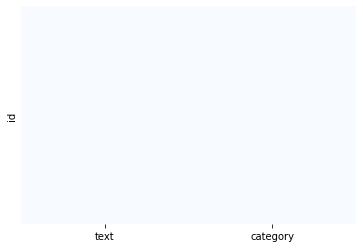

In [5]:
 sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap="Blues")

See the list of labels 


Show the distribution 

In [6]:

# fig = plt.figure(figsize=(8,6))
# df.groupby('text').category.count().plot.bar(ylim=0)
# plt.show()

In [7]:
possible_labels = df.category.unique()
print(possible_labels)

['nocode' 'happy' 'not-relevant' 'angry' 'disgust|angry' 'disgust'
 'happy|surprise' 'sad' 'surprise' 'happy|sad' 'sad|disgust' 'sad|angry'
 'sad|disgust|angry']


In [8]:
df.category.value_counts()

nocode               1572
happy                1137
not-relevant          214
angry                  57
surprise               35
sad                    32
happy|surprise         11
happy|sad               9
disgust|angry           7
disgust                 6
sad|disgust             2
sad|angry               2
sad|disgust|angry       1
Name: category, dtype: int64

# Preprocess Data

In [9]:
# delete tweets that have two categories in the same time
df = df[~df.category.str.contains('\|')]

In [10]:
# delete the tweets with the category 'nocode'
df = df[df.category != 'nocode']
df.category.value_counts()

happy           1137
not-relevant     214
angry             57
surprise          35
sad               32
disgust            6
Name: category, dtype: int64

In [11]:
label_dict = {}
for index,possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'angry': 3,
 'disgust': 5,
 'disgust|angry': 4,
 'happy': 1,
 'happy|sad': 9,
 'happy|surprise': 6,
 'nocode': 0,
 'not-relevant': 2,
 'sad': 7,
 'sad|angry': 11,
 'sad|disgust': 10,
 'sad|disgust|angry': 12,
 'surprise': 8}

In [12]:
df['label']= df.category.replace(label_dict)
df

,text,category,label
id,,,
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy,1
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy,1
614877582664835073,@Sofabsports thank you for following me back. ...,happy,1
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy,1
611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy,1
...,...,...,...
611258135270060033,@_TheWhitechapel @Campaignforwool @SlowTextile...,not-relevant,2
612214539468279808,“@britishmuseum: Thanks for ranking us #1 in @...,happy,1
613678555935973376,MT @AliHaggett: Looking forward to our public ...,happy,1


## Training/Validation Split

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_val,y_train,y_val = train_test_split(
    df.index.values,
    df.label.values,
    test_size = 0.15,
    random_state = 17,
    stratify = df.label.values
)

In [14]:
df['data_type']=['not_set']*df.shape[0]
df.head()

,text,category,label,data_type
id,,,,
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy,1,not_set
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy,1,not_set
614877582664835073,@Sofabsports thank you for following me back. ...,happy,1,not_set
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy,1,not_set
611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy,1,not_set


In [15]:
df.loc[X_train,'data_type'] ='train'
df.loc[X_val,'data_type'] ='val'

In [16]:
df.groupby(['category','label','data_type']).count()

text
category     label data_type      
angry        3     train        48
                   val           9
disgust      5     train         5
                   val           1
happy        1     train       966
                   val         171
not-relevant 2     train       182
                   val          32
sad          7     train        27
                   val           5
surprise     8     train        30
                   val           5

# Naive Bayes Classifier

# BERT

## Loading Tokenizer and Encoding Data

In [17]:
!pip install transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

     |████████████████████████████████| 2.1MB 8.1MB/s 
     |████████████████████████████████| 3.3MB 52.3MB/s 
     |████████████████████████████████| 901kB 54.3MB/s 


In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case = True )

In [19]:
encoded_data_train = tokenizer.batch_encode_plus(df[df.data_type=='train'].text.values,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                 pad_to_max_length = True,
                                                 max_length = 256,
                                                 return_tensors = 'pt'
                                        )

encoded_data_val = tokenizer.batch_encode_plus(df[df.data_type=='val'].text.values,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                 pad_to_max_length = True,
                                                 max_length = 256,
                                                 return_tensors = 'pt'
                                        )

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val= encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [20]:
dataset_train = TensorDataset(input_ids_train,attention_masks_train,labels_train)
len(dataset_train)

1258

In [21]:
dataset_val = TensorDataset(input_ids_val,attention_masks_val,labels_val)
len(dataset_val)

223

## Setting up BERT Pretrained Model

In [22]:
from transformers import BertForSequenceClassification

In [23]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels = len(label_dict),
                                                      output_attentions = False,
                                                      output_hidden_states = False
                                     )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## Data Loaders

In [24]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32
dataloader_train = DataLoader(
    dataset_train,
sampler= RandomSampler(dataset_train))

dataloader_val = DataLoader(
    dataset_val,
sampler= RandomSampler(dataset_val),
batch_size = 32)

## Setting Up Optimizer and Scheduler


In [25]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [26]:
optimizer = AdamW(
model.parameters(),
lr=1e-5,
    eps= 1e-5)

In [27]:
epochs = 2 # 10
total_steps = len(dataloader_train)*epochs
scheduler  = get_linear_schedule_with_warmup(
optimizer,
    num_warmup_steps=0,
num_training_steps = total_steps )

## Defining Performance Metrics

In [28]:
from sklearn.metrics import f1_score

In [29]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat,preds_flat,average ='weighted')

In [30]:
def accuracy_per_class(preds, labels):
    label_dict_inversed = {v : k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat == label]
        y_true = labels_flat[labels_flat== label]
        
        print(f'Class :{label_dict_inversed[label]}')
        print(f'Acc :{len(y_preds[y_preds==label])}/{len(y_true)}\n')

 ## Training Loop

In [31]:
import random
import numpy as np

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [32]:
device = torch.device('cuda' if torch.cuda.is_available()else 'cpu')
model.to(device)
print(device)

cuda


In [33]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals


In [34]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train() # 
    
    loss_train_total = 0
    
    progress_bar =tqdm(dataloader_train,desc = 'Epoch {:1d}'.format(epoch),leave = False,
                      disable=False)
        
    for batch in progress_bar : 
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        
        inputs  = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels' : batch[2]
        }
        
        outputs = model(**inputs)
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm(model.parameters(),1.0)
        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'training_loss ': '{:.3f}'.format(loss.item()/len(batch))})
    torch.save(model.state_dict(),f'Bert_ft_epoch{epoch}.model')
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total / len(dataloader_train)
    tqdm.write(f'Training loss : {loss_train_avg} ')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss : {val_loss}')
    
    tqdm.write(f'f1 score : {val_f1}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.



Epoch 1
Training loss : 1.0511657529941238 
Validation loss : 0.8401475719043187
f1 score : 0.7832769920662298



Epoch 2
Training loss : 0.6067194281357292 
Validation loss : 0.8925809519631522
f1 score : 0.783737581448356



## Loading and Evaluating our Model

In [35]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [36]:
model.to(device)
pass

In [38]:
model.load_state_dict(torch.load('Bert_ft_epoch1.model',map_location=torch.device('cpu')))

<All keys matched successfully>

In [39]:
_, predictions, true_vals = evaluate(dataloader_val)

In [40]:
accuracy_per_class(predictions,true_vals)

Class :happy
Acc :160/171

Class :not-relevant
Acc :22/32

Class :angry
Acc :0/9

Class :disgust
Acc :0/1

Class :sad
Acc :0/5

Class :surprise
Acc :0/5

